# Forward Simulation of UXO Detection

In [19]:
# SimPEG functionality
import simpeg.electromagnetics.frequency_domain as fdem
from simpeg import maps
from simpeg.utils import plot_1d_layer_model

# Common Python functionality
import os
import numpy as np
from scipy.constants import mu_0
import matplotlib as mpl
import matplotlib.pyplot as plt

# import uxo object
from UXO_object import UXO_object

mpl.rcParams.update({"font.size": 14})

write_output = False  # Optional

## Define System Parameters

In [20]:
z0 = 0.1 # height of our sensor above the ground (m)
moment = 1 # dipole moment in A*m^2
coil_spacing = 1 # spacing between Rx and Tx coils (m)
min_freq = 1e4 # minimum frequency (Hz)
max_freq = 1e5 # maximum frequency (Hz)
num_freqs = 5 # number of frequencies to use in simulation
soil_conductivity = 1 # conductivity of the soil (S/m)
uxo_conductivity = 1e6 # conductivity of the UXO (S/m)

## Define a 1D Layered Model

In [21]:
class Earth_Layers_1D:
    def __init__(self, background_conductivity, uxo_object):
        self.background_conductivity = background_conductivity
        self.uxo_object = uxo_object
    
    def layers_at_pt(self, pt: tuple):
        intersects = np.array(self.uxo_object.get_vertical_intersects(pt[0], pt[1]))
        layer_thicknesses = np.abs(intersects)
        layer_conductivities = np.r_[self.background_conductivity,
                                          self.uxo_object.conductivity,
                                          self.background_conductivity]
        return layer_thicknesses, layer_conductivities

    def plot_layered_earth(self, pt: tuple):
        layer_thicknesses, layer_conductivities = self.layers_at_pt(pt)

        fig, ax = plt.subplots(1, 1, figsize=(8, 5))

        ax = plot_1d_layer_model(layer_thicknesses, layer_conductivities, scale="log", ax=ax)
        ax.grid(which="both")
        ax.set_xlabel(r"Conductivities ($S/m$)")
        ax.set_ylim([3, 0])
        ax.set_title("1D Layerd Earth")
        plt.show()

In [22]:
class Forward_Freq_Simulation:
    def __init__(self, frequencies: np.ndarray, z0: float, moment: float, coil_spacing: float):
        self.survey = self._create_survey(frequencies, z0, moment, coil_spacing)

    def _create_survey(self, frequencies: np.ndarray, z0: float, moment: float, coil_spacing: float):
        source_location = np.array([0.0, 0.0, z0])
        source_orientation = "z"

        # Receiver properties
        receiver_locations = np.array([coil_spacing, 0.0, z0])
        receiver_orientation = "z"
        data_type = "ppm"  # "secondary", "total" or "ppm"

        source_list = []  # create empty list for source objects

        # loop over all sources
        for freq in frequencies:
            # Define receivers that measure real and imaginary component
            # magnetic field data in ppm.
            receiver_list = []
            receiver_list.append(
                fdem.receivers.PointMagneticFieldSecondary(
                    receiver_locations,
                    orientation=receiver_orientation,
                    data_type=data_type,
                    component="real",
                )
            )
            receiver_list.append(
                fdem.receivers.PointMagneticFieldSecondary(
                    receiver_locations,
                    orientation=receiver_orientation,
                    data_type=data_type,
                    component="imag",
                )
            )

            # Define a magnetic dipole source at each frequency
            source_list.append(
                fdem.sources.MagDipole(
                    receiver_list=receiver_list,
                    frequency=freq,
                    location=source_location,
                    orientation=source_orientation,
                    moment=moment,
                )
            )

        # Define the FDEM survey
        return fdem.survey.Survey(source_list)
    
    def predict_data(self, layer_thicknesses, layer_conductivities):
        log_conductivities_model = np.log(layer_conductivities)
        log_conductivities_map = maps.ExpMap(nP=len(layer_thicknesses)+1)
        
        simulation= fdem.Simulation1DLayered(
            survey=self.survey,
            thicknesses=layer_thicknesses,
            sigmaMap=log_conductivities_map,
        )

        # Predict 1D FDEM Data
        return simulation.dpred(log_conductivities_model)

In [23]:
# create simulated data
frequencies = np.logspace(np.log10(min_freq), np.log10(max_freq), num_freqs)
uxo = UXO_object(np.array([0.0, 0.0, -1.0]), 0.2, 0.1, 0, 0, uxo_conductivity)
earth = Earth_Layers_1D(soil_conductivity, uxo)

In [24]:
sim = Forward_Freq_Simulation(frequencies, z0, moment, coil_spacing)
dpred = sim.predict_data(*earth.layers_at_pt((0.0, 0.0)))

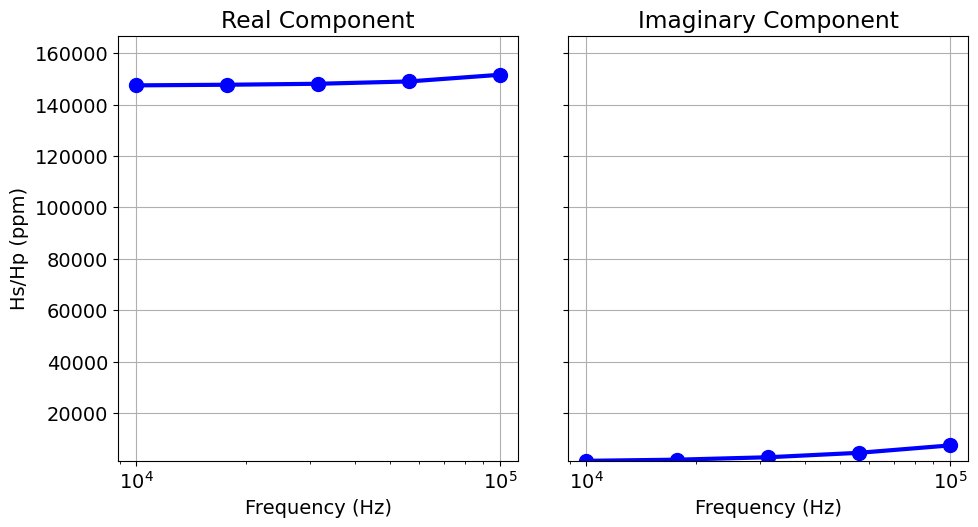

In [25]:
ylim = [np.min(dpred), 1.1 * np.max(dpred)]

fig = plt.figure(figsize=(10, 5))

ax1 = fig.add_axes([0.1, 0.1, 0.4, 0.85])
ax1.semilogx(frequencies, dpred[0::2], "b-o", lw=3, ms=10)
ax1.grid()
ax1.set_ylim(ylim)
ax1.set_xlabel("Frequency (Hz)")
ax1.set_ylabel("Hs/Hp (ppm)")
ax1.set_title("Real Component")

ax2 = fig.add_axes([0.55, 0.1, 0.4, 0.85])
ax2.semilogx(frequencies, dpred[1::2], "b-o", lw=3, ms=10)
ax2.set_ylim(ylim)
ax2.grid()
ax2.set_xlabel("Frequency (Hz)")
ax2.set_yticklabels("")
ax2.set_title("Imaginary Component")

plt.show()

## Save Data

In [30]:
write_output = True

if write_output:
    dir_path = os.path.sep.join(["..", "forward_data"]) + os.path.sep
    if not os.path.exists(dir_path):
        os.mkdir(dir_path)

    np.random.seed(222)
    noise = (
        0.05
        * np.abs(dpred)
        * np.random.normal(size=len(dpred))
    )
    dpred_out = dpred + noise

    fname = dir_path + "em1dfm_data.txt"
    np.savetxt(
        fname,
        np.c_[frequencies, dpred_out[0::2], dpred_out[1::2]],
        fmt="%.4e",
        header="FREQUENCY HZ_REAL HZ_IMAG",
    )